**Auto Reloading**

In [64]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


**Importing Library Function**

In [65]:
import librosa
import tensorflow
import IPython as ipd
import numpy as np
import scipy.signal
from scipy.io import wavfile
import soundfile as sf
import warnings
import matplotlib.pyplot as plt
import urllib.request
import io
%matplotlib inline
from tqdm.autonotebook import tqdm

**Google Colab Requirements**

In [66]:
Google_Colab_requirements = [
    "pip install tensorflow-gpu",
    "pip install librosa",
    "pip install soundfile",
    "pip install pysoundfile"
    "pip install bitstring"
]

import sys, subprocess

def run_subprocess_command(cmd):
    process = subprocess.Popen(cmd.split(), stdout=subprocess.PIPE)
    for line in process.stdout:
        print(line.decode().strip())

IN_GOOGLE_LAB = "google.colab" in sys.modules
if IN_GOOGLE_LAB:
    for i in Google_Colab_requirements:
        run_subprocess_command(i)

**Load Clean file**

In [67]:
Audio_link = "https://raw.githubusercontent.com/timsainb/noisereduce/master/assets/fish.wav"
Audio_response = urllib.request.urlopen(Audio_link)
Clean_data, Clean_rate = sf.read(io.BytesIO(Audio_response.read()))
data = Clean_data


**Play Clean Audio file as 1D array**



In [68]:
ipd.display.Audio(data=Clean_data, rate=Clean_rate)

**Plot Clean Audio file in 2D array i.e time/frequency**

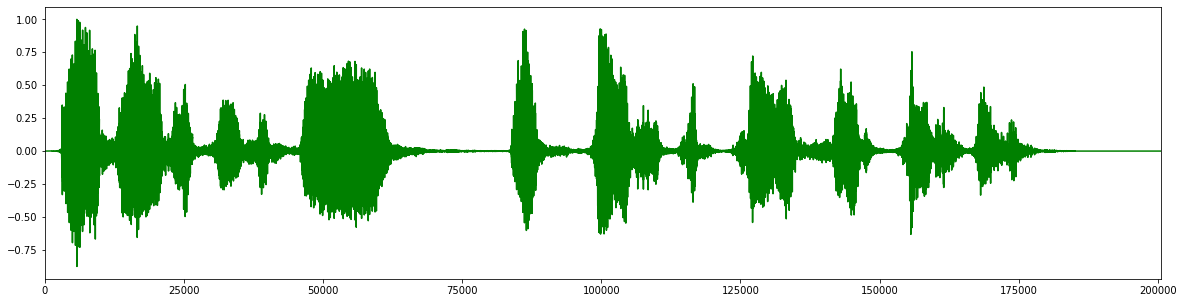

In [69]:
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,5))
plt.plot(data, color='green')
ax.set_xlim((0, len(Clean_data)))
plt.show()

**Load Noise file**

In [70]:
Audio_link= "https://raw.githubusercontent.com/timsainb/noisereduce/master/assets/cafe_short.wav"
Audio_response = urllib.request.urlopen(Audio_link)
Noise_data, Noise_rate = sf.read(io.BytesIO(Audio_response.read()))

**Play Noise Audio file as 1D array**

In [71]:
ipd.display.Audio(data=Noise_data, rate=Noise_rate)

**Plot Noise Audio file in 2D array i.e time/frequency**

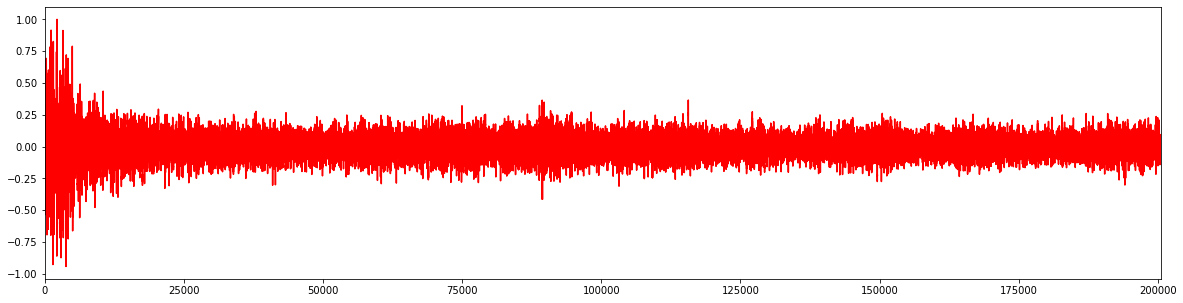

In [72]:
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,5))
plt.plot(Noise_data, color='red')
ax.set_xlim((0, len(Noise_data)))
plt.show()

In [73]:
Noise_data.max()

0.999969482421875

**Add noise to Clean audio using sound to noise ratio**

In [74]:
Sound_to_NoiseRatio = 2 # signal to noise ratio
noise_clip = Noise_data/Sound_to_NoiseRatio
Audio_clip = data + noise_clip

**Play Audio file after adding noise to it as 1D array**

In [75]:
ipd.display.Audio(data=Audio_clip, rate=Noise_rate)

**Plot Audio file after adding noise to it as 2D array**

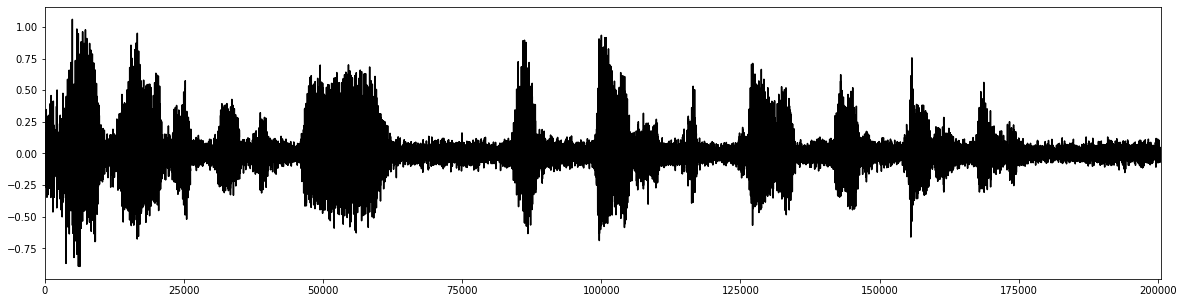

In [76]:
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,5))
plt.plot(Audio_clip, color='black')
ax.set_xlim((0, len(Audio_clip)))
plt.show()

**The STFT represents a signal in the time-frequency domain by computing discrete Fourier transforms (DFT) over short overlapping windows**

In [77]:
def _stft(y, n_fft, hop_length, win_length, used_tensorflow=False):
    if used_tensorflow:
        return _stft_tensorflow(y, n_fft, hop_length, win_length)
    else:
        return librosa.stft(
            y=y, n_fft=n_fft, hop_length=hop_length, win_length=win_length, center=True
        )

**Converts a complex-valued spectrogram stft_matrix to time-series y by minimizing the mean squared error between stft_matrix and STFT of y**

In [78]:
def _istft(y, n_fft, hop_length, win_length, used_tensorflow=False):
    if used_tensorflow:
        return _istft_tensorflow(y.T, n_fft, hop_length, win_length)
    else:
        return librosa.istft(y, hop_length, win_length)

In [79]:
def _stft_librosa(y, n_fft, hop_length, win_length):
    return librosa.stft(
        y=y, n_fft=n_fft, hop_length=hop_length, win_length=win_length, center=True
    )

In [80]:
def _istft_librosa(y, hop_length, win_length):
    return librosa.istft(y, hop_length, win_length)

In [81]:
def _istft_tensorflow(y, n_fft, hop_length, win_length):
    return tf.signal.inverse_ShortTimeFourierTransform(
        y.astype(np.complex64), win_length, hop_length, n_fft
    ).numpy()

In [82]:
def _istft_tensorflow(y, n_fft, hop_length, win_length):
    return tf.signal.inverse_ShortTimeFourierTransform(
        y.astype(np.complex64), win_length, hop_length, n_fft
    ).numpy()

**Conversion of amplitude to Decibel**

In [83]:
def _amplitude_to_decibel(x):
    return librosa.core.amplitude_to_db(x, ref=1.0, amin=1e-20, top_db=80.0)

**Conversion of decibel to amplitude**

In [84]:
def _decibel_to_amplitude(x,):
    return librosa.core.db_to_amplitude(x, ref=1.0)

**Progress bar Loading to show recovered signal**

In [85]:
def _progress_update_bar(Progess_bar, message):
    if Progess_bar is not None:
        Progess_bar.set_description(message)
        Progess_bar.update(1)

**Smoothening filter to enhance audio files to have low lossy file**

In [86]:
def _smoothing_filter(n_grad_freq, n_grad_time):
    smoothing_filter = np.outer(
        np.concatenate(
            [
                np.linspace(0, 1, n_grad_freq + 1, endpoint=False),
                np.linspace(1, 0, n_grad_freq + 2),
            ]
        )[1:-1],
        np.concatenate(
            [
                np.linspace(0, 1, n_grad_time + 1, endpoint=False),
                np.linspace(1, 0, n_grad_time + 2),
            ]
        )[1:-1],
    )
    smoothing_filter = smoothing_filter / np.sum(smoothing_filter)
    return smoothing_filter

**Masking of signals to block certain signals**

In [87]:
def Masking_signal(sig_ShortTimeFourierTransform, sig_mask):
    sig_ShortTimeFourierTransform_amp = sig_ShortTimeFourierTransform * (1 - sig_mask)
    return sig_ShortTimeFourierTransform_amp

**Integrate the amount of overlap of one Audio i.e. Noise data as it is shifted over another Audio i.e. Clean data**

In [88]:
def Convolution_Gaussians(sig_mask, smoothing_filter, used_tensorflow=False):
    if used_tensorflow:
        smoothing_filter = smoothing_filter * (
            (np.shape(smoothing_filter)[1] - 1) / 2 + 1
        )
        smoothing_filter = smoothing_filter[:, :, tf.newaxis, tf.newaxis].astype(
            "float32"
        )
        img = sig_mask[:, :, tf.newaxis, tf.newaxis].astype("float32")
        return (
            tf.nn.conv2d(img, smoothing_filter, strides=[1, 1, 1, 1], padding="SAME")
            .numpy()
            .squeeze()
        )
    else:
        return scipy.signal.fftconvolve(sig_mask, smoothing_filter, mode="same")

**Load Tensorflow**

In [89]:
def load_tensorflow(verbose=False):
    try:
        globals()["tf"] = __import__("tensorflow")

        if verbose:
            available_gpus = tf.config.experimental.list_physical_devices("GPU")
            print("GPUs available: {}".format(available_gpus))
        if int(tf.__version__[0]) < 2:
            warnings.warn(
                "Tensorflow version is below 2.0, reverting to non-tensorflow backend"
            )
            return False
    except:
        warnings.warn(
            "Tensorflow is not installed, reverting to non-tensorflow backend"
        )
        return False
    return True

**De Noiser function which will remove noise from audio based upon a clip containing only noise and recovered signal with noise suppression**

In [90]:
def De_Noiser(
    Audio_generated,
    noise_clip,
    n_grad_freq=2,
    n_grad_time=4,
    n_fft=2048,
    win_length=2048,
    hop_length=512,
    Threshhold_length=1.5,
    prop_decrease=1.0,
    pad_clipping=True,
    used_tensorflow=False,
    verbose=False,
):
    if used_tensorflow:
        used_tensorflow = load_tensorflow(verbose)

    if verbose:
        Progess_bar = tqdm(total=7)
    else:
        Progess_bar = None

    _progress_update_bar(Progess_bar, "STFT on noise")
    noise_ShortTimeFourierTransform = _stft(
        noise_clip, n_fft, hop_length, win_length, used_tensorflow=used_tensorflow
    )
    noise_ShortTimeFourierTransform_db = _amplitude_to_decibel(np.abs(noise_ShortTimeFourierTransform))
    _progress_update_bar(Progess_bar, "STFT on signal")
    mean_freq_noise = np.mean(noise_ShortTimeFourierTransform_db, axis=1)
    std_freq_noise = np.std(noise_ShortTimeFourierTransform_db, axis=1)
    noise_thresh = mean_freq_noise + std_freq_noise * Threshhold_length

    _progress_update_bar(Progess_bar, "STFT on signal")

    if pad_clipping:
        nsamp = len(Audio_generated)
        Audio_generated = np.pad(Audio_generated, [0, hop_length], mode="constant")

    sig_ShortTimeFourierTransform = _stft(
        Audio_generated, n_fft, hop_length, win_length, used_tensorflow=used_tensorflow
    )

    sig_ShortTimeFourierTransform_db = _amplitude_to_decibel(np.abs(sig_ShortTimeFourierTransform))
    _progress_update_bar(Progess_bar, "Generate mask")

    db_thresh = np.repeat(
        np.reshape(noise_thresh, [1, len(mean_freq_noise)]),
        np.shape(sig_ShortTimeFourierTransform_db)[1],
        axis=0,
    ).T

    sig_mask = sig_ShortTimeFourierTransform_db < db_thresh
    _progress_update_bar(Progess_bar, "Smooth mask")

    smoothing_filter = _smoothing_filter(n_grad_freq, n_grad_time)

    sig_mask = Convolution_Gaussians(sig_mask, smoothing_filter, used_tensorflow)

    sig_mask = sig_mask * prop_decrease
    _progress_update_bar(Progess_bar, "Apply mask")

    sig_ShortTimeFourierTransform_amp = Masking_signal(sig_ShortTimeFourierTransform, sig_mask)

    _progress_update_bar(Progess_bar, "Recover signal")

    recovered_signal = _istft(
        sig_ShortTimeFourierTransform_amp, n_fft, hop_length, win_length, used_tensorflow=used_tensorflow
    )

    if pad_clipping:
        recovered_signal = librosa.util.fix_length(recovered_signal, nsamp)

    recovered_spec = _amplitude_to_decibel(
        np.abs(
            _stft(
                recovered_signal,
                n_fft,
                hop_length,
                win_length,
                used_tensorflow=used_tensorflow,
            )
        )
    )
    if verbose:
        Plot_reduction_(
            noise_ShortTimeFourierTransform_db,
            mean_freq_noise,
            std_freq_noise,
            noise_thresh,
            smoothing_filter,
            sig_ShortTimeFourierTransform_db,
            sig_mask,
            recovered_spec,
        )
    return recovered_signal

**Plotting Spectrogram with given statistics and Plot reduction**

In [91]:
def Spectrogram_plotting(signal, title):
    fig, ax = plt.subplots(figsize=(20, 4))
    cax = ax.matshow(
        signal,
        origin="lower",
        aspect="auto",
        cmap=plt.cm.afmhot,
        vmin=-1 * np.max(np.abs(signal)),
        vmax=np.max(np.abs(signal)),
    )
    fig.colorbar(cax)
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

In [92]:
def Stats_Filter_Plotting(
    mean_freq_noise, std_freq_noise, noise_thresh, smoothing_filter
):
    fig, ax = plt.subplots(ncols=2, figsize=(20, 4))
    (plt_mean,) = ax[0].plot(mean_freq_noise, label="Mean power of noise")
    (plt_std,) = ax[0].plot(std_freq_noise, label="Std. power of noise")
    (plt_std,) = ax[0].plot(noise_thresh, label="Noise threshold (by frequency)")
    ax[0].set_title("Threshold for mask")
    ax[0].legend()
    cax = ax[1].matshow(smoothing_filter, origin="lower")
    fig.colorbar(cax)
    ax[1].set_title("Filter for smoothing Mask")
    plt.show()

In [93]:
def Plot_reduction_(
    noise_ShortTimeFourierTransform_db,
    mean_freq_noise,
    std_freq_noise,
    noise_thresh,
    smoothing_filter,
    sig_ShortTimeFourierTransform_db,
    sig_mask,
    recovered_spec,
):

    Spectrogram_plotting(noise_ShortTimeFourierTransform_db, title="Noise")
    Stats_Filter_Plotting(
        mean_freq_noise, std_freq_noise, noise_thresh, smoothing_filter
    )
    Spectrogram_plotting(sig_ShortTimeFourierTransform_db, title="Signal")
    Spectrogram_plotting(sig_mask, title="Mask applied")
    Spectrogram_plotting(recovered_spec, title="Recovered spectrogram")

**Recovered audio file via calling Audio Denoiser function**

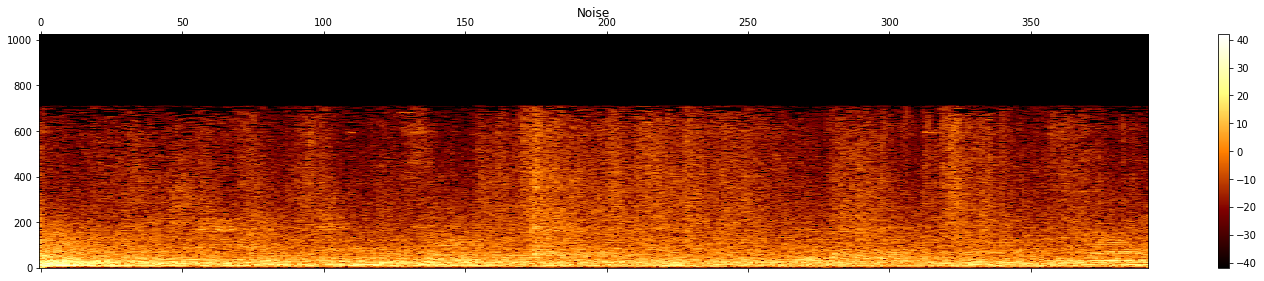

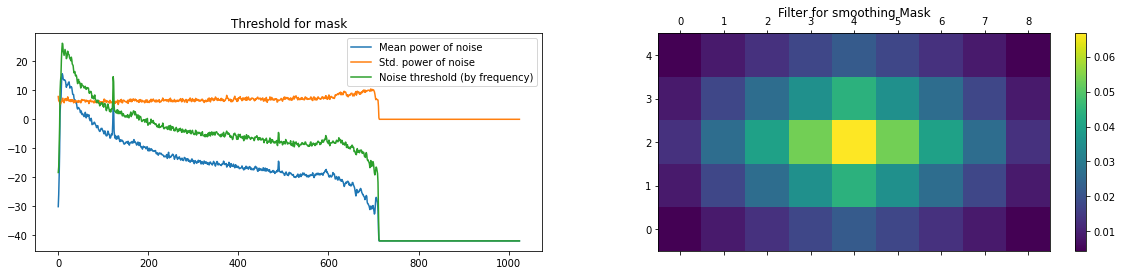

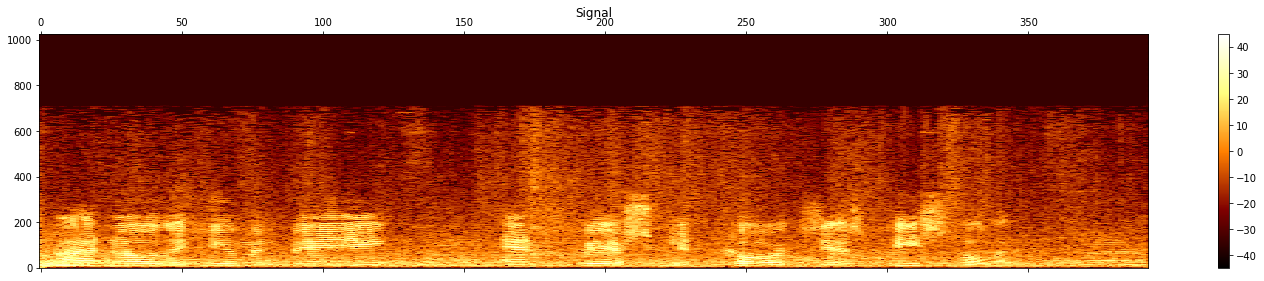

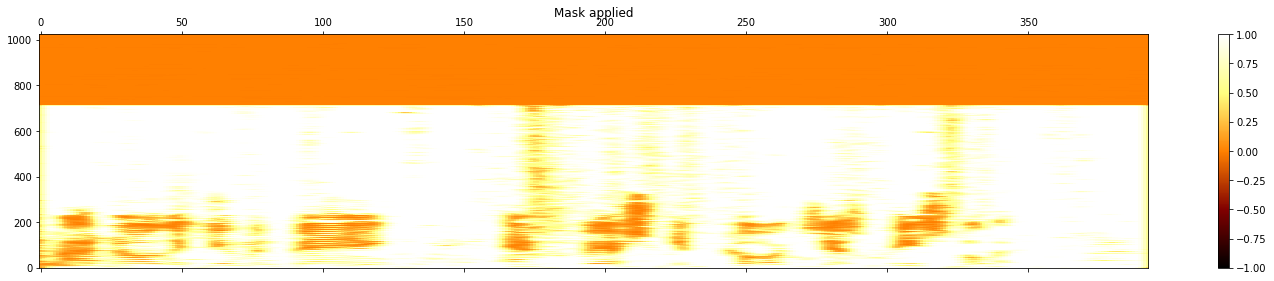

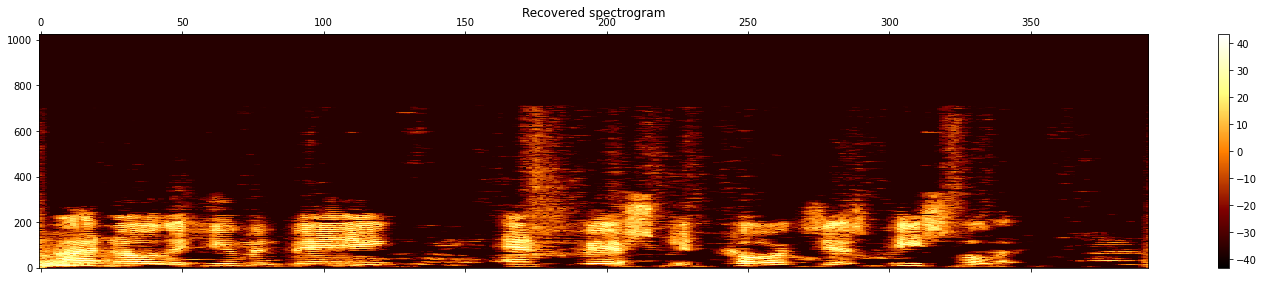

In [94]:
Recovered_noise = De_Noiser(Audio_generated=Audio_clip, noise_clip=noise_clip, verbose=True)

**Play recovered file after suppressing noise from audio clip as 2D array**

In [95]:
ipd.display.Audio(data=Recovered_noise, rate=Noise_rate)

**Plot recovered file after suppressing noise from audio clip as 2D array**

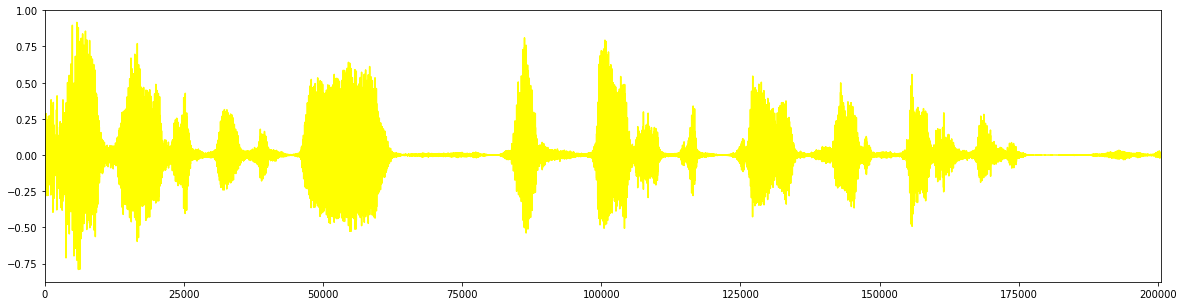

In [96]:
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,5))
plt.plot(Recovered_noise, color='yellow')
ax.set_xlim((0, len(Recovered_noise)))
plt.show()

**Plot Audio clip after adding noise to clean audio in Red and Recovered Audio signal as black**

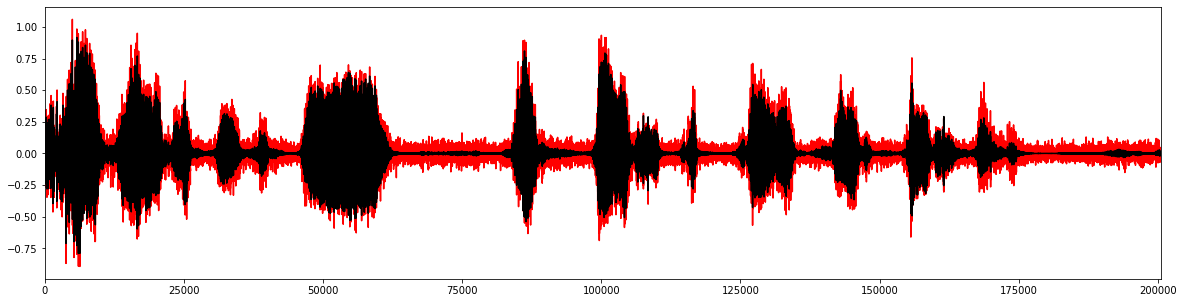

In [97]:
fig, ax = plt.subplots(nrows=1,ncols=1, figsize=(20,5))
plt.plot(Audio_clip, color='red')
plt.plot(Recovered_noise, color='black')
ax.set_xlim((0, len(Audio_clip)))
ax.set_xlim((0, len(Recovered_noise)))
plt.show()

**Play Recovered audio**

In [98]:
ipd.display.Audio(data=Recovered_noise, rate=Noise_rate)

In [99]:
%%timeit
Recovered_noise = De_Noiser(Audio_generated=Audio_clip.astype('float32'),
                                noise_clip=noise_clip.astype('float32'),
                                used_tensorflow=False, 
                                verbose=False)

10 loops, best of 5: 134 ms per loop


In [100]:
longer_clip = np.concatenate([Audio_clip.astype('float32') for i in range(100)])
print("Clip is {} seconds long.".format(round(len(longer_clip)/Noise_rate)))

Clip is 455 seconds long.


In [101]:
%%time
# non-tensorflow
Recovered_noise = De_Noiser(Audio_generated=longer_clip,
                                noise_clip=noise_clip.astype('float32'),
                                used_tensorflow=False, 
                                verbose=False)

CPU times: user 11.7 s, sys: 245 ms, total: 12 s
Wall time: 12 s


In [104]:
Recovered_noise = De_Noiser(Audio_generated=data, noise_clip=noise_clip, prop_decrease=0, verbose=False)

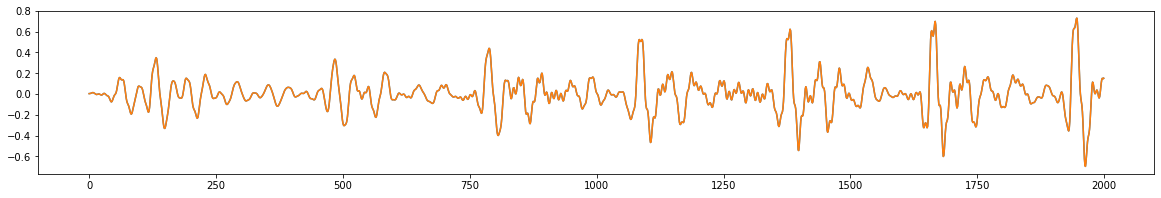

In [103]:
fig, ax = plt.subplots(figsize=(20,3))
ax.plot(Recovered_noise[3000:5000])
ax.plot(data[3000:5000])